In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data cleaning

In [71]:
df = pd.read_csv("./Data/ede-questionnaire-third-round.csv")

In [72]:
questionnaire_raw_data = df
# questionnaire_raw_data = questionnaire_raw_data.dropna(axis=0, how='any')
questionnaire_respones = questionnaire_raw_data[questionnaire_raw_data.trial_type.isin(['table-completion', 'custom-form'])][['mturkID', 'experiment_id', 'trial_type', 'id', 'responses']]


In [73]:
len(questionnaire_respones.mturkID.unique())

126

In [74]:

def clean_table_questions(x):
    dic = {}
    a = json.loads(x)['responses']
    for i in a:
        dic[i] = a[i]['choices'][0]
    return dic

def clean_form_questions(x):
    dic = {}
    for i in json.loads(x):
        dic[i['id']] = i['value']
    return dic

def clean_questions(x,type):
    if(type == 'table-completion'):
        return clean_table_questions(x)
    elif(type == 'custom-form'):
        return clean_form_questions(x)
    else:
        return x

In [75]:
questionnaire_respones['clean_responses'] =  questionnaire_respones.apply(lambda x: clean_questions(x['responses'],x['trial_type']), axis=1)
questionnaire_respones.clean_responses = questionnaire_respones.clean_responses.apply(lambda x: list(x.items()))
a = questionnaire_respones.groupby('mturkID').agg({'clean_responses': 'sum'}).reset_index()
a['clean_responses_dict'] = a.clean_responses.apply(lambda x: dict(x))


In [76]:
df_dict = {}

for i in a.iterrows():
    df_dict[(i[1]['mturkID'])] = i[1]['clean_responses_dict']
questionnaire_clean_data = pd.DataFrame(df_dict).transpose().reset_index()
for i in range(0,48):
    questionnaire_clean_data[str(i+1)] =(questionnaire_clean_data[str(i+1)].astype(float))

In [80]:
questionnaire_clean_data['restraint'] = ((questionnaire_clean_data['1']) + questionnaire_clean_data['2'] + questionnaire_clean_data['3'] + (questionnaire_clean_data['4']) + (questionnaire_clean_data['5']))/5

questionnaire_clean_data['eating_concern'] = ((questionnaire_clean_data['7']) + questionnaire_clean_data['9'] + questionnaire_clean_data['20'] + (questionnaire_clean_data['19']) + (questionnaire_clean_data['21']))/5
questionnaire_clean_data['weight_concern'] = ((questionnaire_clean_data['22']) + questionnaire_clean_data['24'] + questionnaire_clean_data['8'] + (questionnaire_clean_data['25']) + (questionnaire_clean_data['12']))/5
questionnaire_clean_data['shape_concern'] = ((questionnaire_clean_data['6']) + questionnaire_clean_data['8'] + questionnaire_clean_data['23'] + (questionnaire_clean_data['10']) + (questionnaire_clean_data['26']) \
    + questionnaire_clean_data['27'] + questionnaire_clean_data['28'] + questionnaire_clean_data['11'])/8
questionnaire_clean_data['global_score'] = (questionnaire_clean_data['restraint'] + questionnaire_clean_data['eating_concern'] + questionnaire_clean_data['weight_concern'] + questionnaire_clean_data['shape_concern'])/4

questionnaire_clean_data['height_m'] = questionnaire_clean_data['heightfeet'].astype(float) * 0.3048 + questionnaire_clean_data['heightinch'].astype(float) * 0.0254 
questionnaire_clean_data['weight_kg'] = questionnaire_clean_data['weight'].astype(float)*0.453592
questionnaire_clean_data['BMI'] = questionnaire_clean_data['weight_kg']/questionnaire_clean_data['height_m']**2

questionnaire_clean_data['var_likert'] = questionnaire_clean_data[['1','2','3','4','5', '6', '7', '8','9','10','11','12','19','20','21','22','23','24','25','26','27','28']].std(axis=1)

a = (np.zeros(questionnaire_clean_data.shape[0]))

for i in range(29, 49):
    a += questionnaire_clean_data[str(i)]/20 

questionnaire_clean_data['desire_to_control'] = a


# Apply exclusion criteria

In [82]:
questionnaire_clean_data = questionnaire_clean_data[questionnaire_clean_data.var_likert != 0]

# sanity check

<AxesSubplot:xlabel='global_score', ylabel='BMI'>

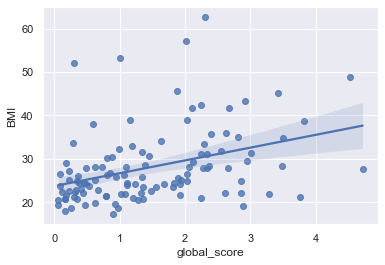

In [83]:
sns.regplot(x='global_score', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='restraint', ylabel='BMI'>

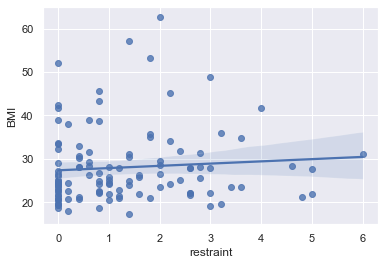

In [84]:
sns.regplot(x='restraint', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='eating_concern', ylabel='BMI'>

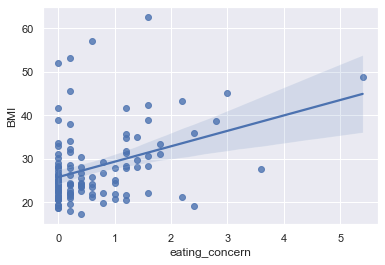

In [85]:
sns.regplot(x='eating_concern', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='shape_concern', ylabel='BMI'>

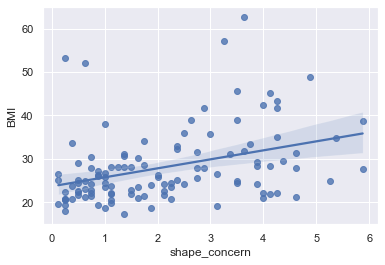

In [86]:
sns.regplot(x='shape_concern', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='weight_concern', ylabel='BMI'>

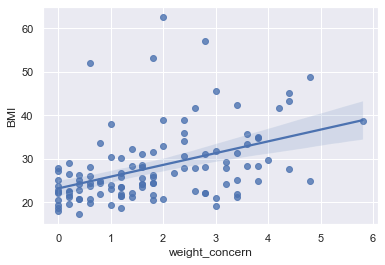

In [87]:
sns.regplot(x='weight_concern', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='desire_to_control', ylabel='global_score'>

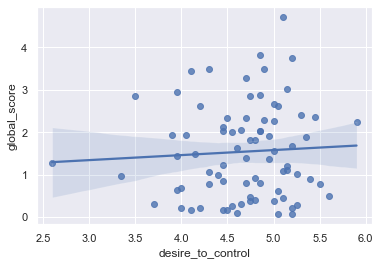

In [89]:
sns.regplot(x='desire_to_control', y='global_score', data=questionnaire_clean_data)

In [94]:
questionnaire_clean_data.to_csv('./Data/cleaned_questionnaire_data.csv')